# Neural Network Tutorial

This is a tutorial to implement a feedforward neural network with backpropagation training using learning and momentum rate parameters. This is the "hello world" of neural networks and forms the basis for many different network training techniques. Some other interesting network architectures are residual backpropagation, quick prop, and more, and while they do similar things, I'm only focusing on a vanilla backpropagation network. Feel free to distribute, edit, make changes, improve, etc. this tutorial. If you publish this tutorial elsewhere, please let me know and link back.

## Neural Networks

Neural networks are a bioinspired network of neurons used for predictive modeling. Its structure as a group of associated neurons can be used for artificial intelligence and machine learning applications. I won't go into the history of neural networks (I'll leave it as an exercise to the reader) but surprisingly these have been around in some fashion or another since the 60s but only really came into vogue in the 90s and beyond.

To put it in layman's terms, a neural network connects different learning units together in a network structure. Each learning unit--or neuron--in the network uses a mathematical or computational model for information processing. Each neuron accepts an input signal which processes the signal and passes it to its neural output. When training data is fed into the network, the network weights change to reflect the fed data, and over time and enough training examples, the network would (hopefully) learn to generalize for novel data.

This tutorial won't go into a lot of math. Sure, it's here, but it's been simplified dramatically. You should read Mitchell's text on machine learning to know the intricacies of neural networks, but I personally don't really learn that way and much prefer there to be as little math as possible.

### Learning

An example neural network is below:

<img src="./images/network-diagram.png"/>

This is often referred to as a 3-2-3 network, or one which consists of three neurons in the input layer, two neurons in the hidden layer, and three neurons in the output layer. Each layer has its neurons interconnected with the next with these connections referred to as synapses.

Data flows into the neural network from the input layer (where the count of neurons equals the dimensionality of the data, i.e. how many features the data has), passes through to the next layer but not before passing a summing and activation function, meant to aggregate the data and process it to match the number of outputs. This process is referred to as feed-forward, or the forward pass of the network. This works in one direction. 

The output layer, however, consists of neurons equal to the number of classes the specific problem has. Once data reaches here, each neuron outputs a continuous value correlating to how much the network is confident that piece of data corresponds to a given class. The number of classes is problem specific and like the input layer, is generally denoted by the problem and not by the user.

How the system learns is that once every training example was fed forward through the network, you can identify how erroneous classification was by comparing the output received versus the target output. Since this is supervised learning, the class of a training example is known, and comparing this to what was received, the network can correct its synapse weights to better come to a correct solution.

Once the error is found, it is fed backwards into the network, referred to as backpropagation, and stored in each neuron. When the synapse weights are updated, they correct themselves based on this error (and other network parameters).

This process of feedforward and backpropagation is done many times until the error is reduced sufficiently enough. A typical network may just guess at a solution, but after training, it will be a more informed decision and the network will be a more confident classifier.

### Pseudocode

Pseudocode for the algorithm is as below:

```
procedure nn() is:
  initialize network structure
  initialize random weights for each synapse
  for each epoch do:
    for each training example ex do:
      feed-forward ex through layers 0..n
      find error e as a function of actual and target outputs
      back-propagate e through layers n..0
      update weights w as a function of w, e, network params
    endfor
  endfor
endprocedure
```

## Before you begin

This tutorial uses Python and one dependency which needs to be met:

- Python 3.6
- GNU/Linux (or WSL, LXSS, etc)
- X11 or alternative
- `matplotlib`
- some data

I'll leave it as an exercise to the reader on how to meet these dependencies. I will, however, be using the Iris data set (see `/data`) but I'll be implementing the neural network to be as general as possible, i.e. able to take any data set and automatically configure itself to meet the demands of the data.

`matplotlib` is not entirely necessary for the final program, but this tutorial does use it for illustrative purposes.

## Loading the Data

Before I begin my implementation, I need to handle how data is read and stored. 

The Iris data set consists of 150 examples of 4-dimensional data (four continuous features per row) along with a discrete classification (class count of three). I've renamed the classes as numbers (`0, 1, 2`) so I remain using numbers. For reference, a class of `0` means Iris-setosa, `1` means Iris-versicolor, and `2` means Iris-virginica.

We don't want one collection of data. Rather, we want a split of training and testing data. A very common ratio is 70% training data, 30% testing data; you can, of course, experiment with other ratios but 70/30 is very common. The bigger chunk will be used to train the network and the smaller to verify its performance. 

Here we'll load the data and split it into training and testing data.

In [1]:
import csv
import random
from math import floor, ceil

def load_data(filename):
    """Loads CSV for splitting into training and testing data.
    
    Parameters:
        filename : the filename of the file to load.
    
    Returns:
        Two lists, each corresponding to training and testing data.
    """
    with open(filename, newline='\n') as csv_file: # open CSV
        data = [] # store data as a master list
        rows = csv.reader(csv_file, delimiter=',') # get each row
        for row in rows: # for each row
            data.append(row) # add to data list
    random.shuffle(data) # randomize data order
    training_data = data[:floor(len(data)*0.70)] # 70% split train
    testing_data = data[-ceil(len(data)*0.30):] # 30% split test
    return training_data, testing_data

TRAIN, TEST = load_data('./data/iris.csv')

print(f'Training examples: {len(TRAIN)}')
print(f'Testing examples: {len(TEST)}')

Training examples: 105
Testing examples: 45


Now we have 70% of the data stored as training data and the remainder as testing data. It's also useful to count the number of features and the number of unique classifications of the data to best initialize our network layer:

In [2]:
FEATURES = len(TRAIN[0][:-1]) # count number of attributes
CLASSES = len(list(set([c[-1] for c in TRAIN]))) # count number of unique classifications

print(f'Features: {FEATURES}, Classes: {CLASSES}')

Features: 4, Classes: 3


This remains consistent with the known characteristics of the data set. We'll use these counts when initializing the network, as we want four input neurons and three output neurons. This is where the input layer and output layer sizes are determined: these counts are not user defined but instead a consequence of the data.

## Initializing the Network

In order to make the network, we need to know the number of input neurons, the number of output neurons, but also some number of hidden layers and hidden neurons. To keep it simple, I'll keep it to one hidden layer with five neurons. Since we already know the size of the input and output layers, the final network structure will be 4-5-3.

Some like to make a neuron class and create a network using object orientation but I think it's simpler to use standard containers from Python like lists and dictionaries.

When making the network, we're also describing the weights of the synapses between neurons. Each neuron is connected to each neuron in the next layer, and these connections have a weight for them paramount to learning. There's different literature on how weights should be initialized; for example, in the range `[0.00, 1.00]`, `[-1.00, 1.00]`, and so on. I like `[-0.50, 0.50]`. Each neuron outside of the first also has a bias connected to it.

In [3]:
def initialize_network(n, h, o):
    """Neural network initializer.
    
    Parameters:
        n : the number of input neurons.
        h : the number of hidden neurons.
        o : the number of output neurons.
    
    Returns:
        An n-h-o neural network as a list of list of dicts.
    """
    def r(): # an inline function to generate randomly uniform numbers
        return random.uniform(-0.50, 0.50)
    neural_network = [] # initially an empty list
    # there are (n * h) connections between input layer and hidden layer
    # a 'w' will denote weights
    neural_network.append([{'w':[r() for i in range(n+1)]} for j in range(h)])
    # there are (h * o) connections between hidden layer and output layer
    neural_network.append([{'w':[r() for i in range(h+1)]} for j in range(o)])
    return neural_network

NETWORK = initialize_network(FEATURES, 5, CLASSES)

While a visualization will be ugly, you can see all of the network weights by printing the network:

In [4]:
for layer in NETWORK:
    for neuron in layer:
        print(neuron)
    print('\n')

{'w': [ 0.3775,  0.2912,  0.0728, -0.4050,  0.4747]}
{'w': [-0.3037, -0.2640, -0.2546,  0.2884,  0.2068]}
{'w': [-0.4138,  0.3322,  0.3602, -0.1637, -0.3013]}
{'w': [-0.2697,  0.1121, -0.1494,  0.4448,  0.3078]}
{'w': [-0.4629, -0.1226, -0.0236, -0.1642,  0.2739]}

{'w': [ 0.4451,  0.0094, -0.4016, -0.4020, -0.2512, -0.3907]}
{'w': [-0.4953,  0.4005, -0.1817,  0.1714,  0.0477,  0.3311]}
{'w': [ 0.0487,  0.4486, -0.0608,  0.4802, -0.2886, -0.2563]}


I've truncated each weight to four decimal places for readability. You can make a little bit of sense of this by counting the `w` as found above: there's eight because we have eight sets of connections (five sets from hidden layer to input layer and three sets from output layer to hidden layer). As well there's two "layers" of connections, as there's one "layer" of connections connecting the input layer to hidden layer, then another from hidden layer to output layer.

The first five sets of weights correspond to the connections between the input and hidden layer. Note there's five weights despite only four input neurons: this is the bias, an extra weight used to normalize the data. As far as I'm aware, a bias is not necessarily all of the time but is good practice to include as it does not harm the network by addition. Likewise, the following three sets of weights are of length six in a similar way.

Seeing the network is not terribly important right now, so this is just to verify that weights were randomly initialized within the specified range of `[-0.50, 0.50]`.

## Feeding Data Forward

As previously mentioned, one of the steps to training the network is feeding data forward through the network. Data enters the input layer, is processed by the input neurons, then fed into the hidden layer and the cycle repeats until data reaches the output layer.

The "processing" I mention is by use of a summing and activation function. Here is what a neuron looks like:

<img src="./images/neuron-diagram.png"/>

For this example, it is a neuron with three neural inputs. It collects the input data, performs a summation (S), then sends that summation to the activation function (T), which sends its activation as output.

### Summing Function

The summing function takes neural inputs and aggregates them to be sent to the next layer. In our network, for example, one of the hidden neurons takes four inputs but only one output (albeit three times). How do you convert four inputs to one output? You would take the input signals, multiply them by the weights of the connections to reach the neuron, and sum these values up. Each weight is "how much" of that input it considers for summation and can be signed in either direction.

The summation is found as:

$$S = \sum_i^n{(w_i \times x_i)} + b$$

Where $n$ is the length of the weight vector, $b$ is the neural bias, $w$ and $x$ are the weights and inputs respectively.

This can be trivially implemented:

In [5]:
def summing_function(weights, inputs):
    """Sums the synapse weights with inputs and bias.
    
    Parameters:
        weights : synaptic weights.
        inputs : a vector of inputs.
    
    Returns:
        The aggregate of inputs times weights, plus bias.
    """
    bias = weights[-1] # bias is the final value in the weight vector
    summ = 0.00 # to sum
    for i in range(len(weights)-1):
        summ += (weights[i] * float(inputs[i])) # aggregate the weights with input values
    return summ + bias

This will crunch the four inputs into one output based on the synapse weights connecting the inputs to the neuron and subsequently sending it to the activation function.

### Activation Function

The activation signifies the differences in neuron activation or firing. Typically, as is the case with linear activations, it will be a binary "ON" or "OFF". But, using non-linear activations you can have a continuous range of "ON-ness", or probabilities of being fired. The activation function we'll be using is the logarithmic sigmoid function:

$$log(z) = \frac{1}{1 + e^{-z}}$$

Which when implemented is as below:

In [6]:
from math import exp

def activation_function(z):
    """
    Parameters:
        z : summed output of neuron.
    
    Returns:
        The neuron activation based on the summed output.
    """
    return 1 / (1 + exp(-z))

To see what this function does, we can use `matplotlib`:

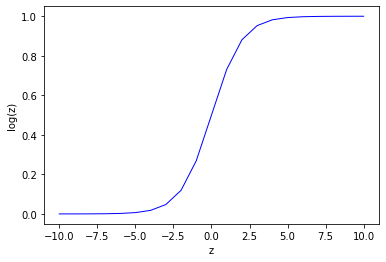

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt

x = range(-10, 10+1, 1)
y = [activation_function(z) for z in x]
plt.plot(x, y, c='blue', lw='1')
plt.ylabel('log(z)')
plt.xlabel('z')
plt.show()
plt.clf()

You can see the function squashes values above and below a certain range, meaning the minimum of the function is `0.0` and the maximum is `1.0`. To put it briefly, larger numbers will cap at `1.0` and smaller numbers will cap at `0.0`. So, if we received a weight summation of, say, `3.14`, the activation of this value is approximately `0.9585`. This function effectively normalizes the weighted sum to `[0.00, 1.00]`.

There are other activation functions you can use, like the hyperbolic tangent function, but for simplicity sake, the logarithmic sigmoid function will suffice.

### Back to Feeding Forward

With both summation and activation functions defined, we can implement the feed-forward function:

In [8]:
def feed_forward(network, example):
    """Feedforward method. Feeds data forward through network.
    
    Parameters:
        network : the neural network.
        example : an example of data to feed forward.
    
    Returns:
        The output of the forward pass.
    """
    layer_input, layer_output = example, []
    for layer in network:
        for neuron in layer:
            summ = summing_function(neuron['w'], layer_input) # sum the weight with inputs
            neuron['o'] = activation_function(summ) # activate the sum, store output
            layer_output.append(neuron['o']) # append output to outputs
        layer_input, layer_output = layer_output, [] # inputs become outputs of previous layer
    return layer_input # return the final output

Data is fed into the network starting at the first layer, it is processed by the neurons in that layer, generating outputs using the summing and activation functions, the outputs are then fed into the next layer as inputs and the cycle repeats until the output layer receives the outputs. The final output from the output layer is the probability that the data example is part of a given class.

We can test this by feeding a couple examples through and investigating their outputs. We'll write a function to pass an example through the network and see its output:

In [9]:
def check_output(network, example):
    """Compares network output to actual output.
    
    Parameters:
        network : the neural network.
        example : an example of data.
    
    Returns:
        The class the example belongs to (based on network guess).
    """
    output = feed_forward(network, example)
    return output.index(max(output))

Each feedforward pass will "light up" each output neurons to a different degree. This is the confidence that the row of data fed into the network corresponds to that class. Recall for our network, there are three output neurons, and the highest neural output in the output layer corresponds to the proposed class. If you were to print each neural output for the output layer, you would see three different values. We've taken the maximum here as our network's prediction.

I'll take the first five training examples, output their class, and compare to the network's outputs:

In [10]:
def test_network_outputs(num):
    for i in range(num):
        print(f'Expected: {int(TRAIN[i][-1])}, Found: {check_output(NETWORK, TRAIN[i])}')

test_network_outputs(5)

Expected: 2, Found: 2
Expected: 0, Found: 2
Expected: 2, Found: 2
Expected: 0, Found: 2
Expected: 2, Found: 2


Not a whole lot to see here. It just happens that the weights were initialized such that the third output neuron's synapse weights were the strongest leading it to classify every example as of the third class. Additionally, since the network isn't trained during the feedforward step, these weights remain the same. Still, we'll make a driver to test everything and output a performance percentage:

In [11]:
def performance_measure(network, data):
    """Measures accuracy of the network using classification error.
    
    Parameters:
        network : the neural network.
        data : a set of data examples.
    
    Returns:
        A percentage of correct classifications.
    """
    correct, total = 0, 0
    for example in data:
        # check to see if the network output matches target output
        if check_output(network, example) == float(example[-1]):
            correct += 1
        total += 1
    return f'{(correct / total):.2%}'

And while it means very little right now, we can run this on the training and testing data to see presumably poor results:

In [12]:
def test_network(network, training_data, testing_data):
    print(f'Accuracy against training data: {performance_measure(network, training_data)}')
    print(f'Accuracy against testing data: {performance_measure(network, testing_data)}')

test_network(NETWORK, TRAIN, TEST)

Accuracy against training data: 34.29%
Accuracy against testing data: 31.11%


Don't forget that for the Iris data set, a random guess is still 33.33%, so these numbers mean very little and amount to not much more than random guessing. But, using backpropagation, we can train the network to generalize and correctly classify data.

## Backpropagating Error

Backpropagation is how the network is trained. After every training example is fed forward through the network, we can identify the error in the output layer based on these values. Then, we can propagate the error through the layers in reverse to determine how much each synapse weight needs to be corrected to come closer to a minimized error. If feed-forward passes outputs through the layers, backpropagation passes errors through the layers in reverse.

We first need an activation derivative function:

In [13]:
def activation_derivative(z):
    """Derivative of logarithmic sigmoid function.
    
    Parameters:
        z : summing output.
    
    Returns:
        The differential of the neural output.
    """
    return z * (1 - z)

This is done to find the gradient of the activation. I'm trying not to use too much math here, but this is because the backpropagated error signal requires an error gradient, and we cannot update the weights without knowing this. The backpropagation algorithm is relatively tame:

In [14]:
def backpropagate(network, example):
    """Backpropagation function. Backpropagates error through network.
    
    Parameters:
        network : the neural network.
        example : a training example.
    """
    for i in range(len(network)-1, -1, -1): # for each reverse order layer
        for j in range(len(network[i])): # for each neuron in the layer
            error = 0.00
            if i == len(network)-1: # if the output layer
                # error is a function of what the output is versus the target
                error = example[j] - network[i][j]['o']
            else: # if an inner layer
                summ = 0.00
                # error is the sum of neuron weights times their deltas
                for neuron in network[i+1]:
                    summ += neuron['w'][j] * neuron['d']
                error = summ
            # delta is amount of correction
            network[i][j]['d'] = activation_derivative(network[i][j]['o']) * error

Using this function, we find the delta (the amount needed by the weights to be corrected) for each neuron. Using this, we can update synapse weights based on network parameters. Some literature doesn't use the delta and instead uses the actual error, but as the delta is a function of the error, it will suffice and saves us a step later. Just think of the delta as the corrective magnitude of the output against the error.

And what are the network parameters? We've got this far; we should probably define them:

### Learning Rate

The learning rate is usually a very small value used to determine how much of the corrective delta to account for when updating the weights. A learning rate of `0.00`, for example, will not learn anything at all, but a larger learning rate of, say, `1.00` means a large portion of the delta is accounted for. There is no right answer here, it is usually empirically found by experimentation, although generally you want the learning rate to be very small, for example `[0.001, 0.100]`.

### Momentum Rate

The momentum rate is similar, but it accounts for temporal delta, or the previous example's inertia in updating weights. If the previous example changed the weights to a large degree, some of that will spill into the next example. It is also parameterized and like the learning rate, is generally small, smaller than the learning rate, even. There's no right answer here either but typically a momentum rate of `[0.000, 0.010]` is appropriate. This is an optional network parameter and usually a network can train fine without it.

If you want the math-y version of why momentum is needed or wanted: since backpropagation aims to reduce or minimize the error function for the network, the gradient of which is not linear, there are many "bumps" in this function, or local minima. If you imagined a linear line in two dimensions but added a few pitfalls to it, if you were to roll a ball down this line, you may get trapped in local minima and never reach the global minima. Momentum can alleviate this.

In order to implement momentum rate, we need to keep track of the prior example's delta which you'll see soon.

## Updating Weights

Since we now have our feedforward and backpropagation functions, now we can define how weights are updated. Weights for this network are updated like below:

$$w_\text{new} = w_\text{old} + (L \times d_\text{current} \times t) + (M \times d_\text{previous})$$

Or, the new weight is the old weight plus a term which encompasses the learning rate with the error delta and training examples, plus a term which encompasses the momentum rate with the temporal delta.

In [15]:
LEARNING_RATE = 0.10
MOMENTUM_RATE = 0.01

def update_weights(network, example, delta):
    """Function to update network weights.
    
    Parameters:
        network : the neural network.
        example : a training example.
        delta : temporal delta.
    """
    for i in range(len(network)): # for each layer in network
        # we update the weights in order of layers 0..n
        # so we need either the example or the outputs of a layer
        if i != 0: # if not first layer
            t = [neuron['o'] for neuron in network[i-1]] # init t as neural outputs
        else: # if first layer
            t = example[:-1] # init t as the training example attributes
        # for each neuron in layer; zip with a length of network variable to access deltas
        for neuron, d in zip(network[i], range(0, len(network[i]))):
            for f in range(len(t)): # for each feature or output of t
                # update weight based on learning rate term
                neuron['w'][f] += LEARNING_RATE * float(t[f]) * neuron['d']
                if delta is not None: # if there is a temporal delta
                    # update weight based on momentum rate term
                    neuron['w'][f] += MOMENTUM_RATE * delta[d]
                # also update neural bias
                neuron['w'][-1] += LEARNING_RATE * neuron['d']

The process of training a backpropagation neural network is referred to as stochastic gradient descent, which is a nice term. If you break it down, the stochastic element comes from the randomized training and testing examples as well as the random initial weights of the network. Gradient descent means we're descending the error gradient as the network is trained by updating the synapse weights as a function of the error and network parameters.

Since we've implemented everything so far, the stochastic gradient descent function is just a main driver for the program and is below:

In [16]:
def stochastic_gradient_descent(network, classes, training_data):
    """Training function for neural network.
    
    Parameters:
        network : the neural network.
        classes : the number of classes for the data.
        training_data : data to train the network on.
    """
    for _ in range(0, 100):
        first_example = True
        for example in training_data:
            # temporal delta exists for examples which are not the first
            temporal_delta = [neuron['d'] \
                for layer in network for neuron in layer] \
                if not first_example else None
            outputs = [0 for _ in range(classes)] # find classes for the example
            outputs[int(example[-1])] = 1 # denote correct class
            feed_forward(network, example) # feed forward example through network
            backpropagate(network, outputs) # backpropagate to find deltas
            update_weights(network, example, temporal_delta) # update the weights
            reset_neurons(network) # reset outputs to 0
            first_example = False

def reset_neurons(network):
    """Resets neural outputs to zero after each backprop pass.
    
    Parameters:
        network : the neural network.
    """
    for layer in network:
        for neuron in layer:
            # we don't want to clobber the outputs later, so reset after every example
            neuron['o'] = 0

This is all the network needs to function and we can test it, comparing the performance with initial conditions versus when the network is trained.

In [17]:
print("Before training:")
test_network(NETWORK, TRAIN, TEST)
print("\nAfter training:")
stochastic_gradient_descent(NETWORK, CLASSES, TRAIN)
test_network(NETWORK, TRAIN, TEST)

Before training:
Accuracy against training data: 34.29%
Accuracy against testing data: 31.11%

After training:
Accuracy against training data: 98.10%
Accuracy against testing data: 95.56%


We can verify this by running our `test_network_outputs()` function again, showing a small amount of data with their expected outputs and actual outputs using the trained network:

In [18]:
test_network_outputs(15)

Expected: 2, Found: 2
Expected: 0, Found: 0
Expected: 2, Found: 2
Expected: 0, Found: 0
Expected: 2, Found: 2
Expected: 2, Found: 2
Expected: 1, Found: 1
Expected: 1, Found: 2
Expected: 2, Found: 2
Expected: 2, Found: 2
Expected: 2, Found: 2
Expected: 2, Found: 2
Expected: 0, Found: 0
Expected: 0, Found: 0
Expected: 2, Found: 2


As expected, with the trained network reporting 98.10% accuracy against training data, it's able to classify this small subset of the data correctly with the exception of one example, which is just a consequence of poor luck (the network isn't 100% accurate, after all).

## Error

But what about the error? We've spent all this time minimizing the error function, but we can't yet visualize how error changes. We need to add an error function (I'll use mean squared error) and change our SGD function to output this.

In [19]:
MSE = [] # a container to store the error over epochs

def sse(actual, target):
    """Sum Square Error loss function. Determines error of network.
    
    Parameters:
        actual : the actual output from the network.
        target : the expected output from the network.
        
    Returns:
        The sum squared error of the network.
    """
    summ = 0.00
    for i in range(len(actual)):
        summ += (actual[i] - target[i])**2
    return summ

def stochastic_gradient_descent(network, classes, training_data):
    for _ in range(0, 350):
        first_example = True
        total_error = 0.00
        for example in training_data:
            temporal_delta = [neuron['d'] \
                for layer in network for neuron in layer] \
                if not first_example else None
            outputs = [0 for _ in range(classes)]
            outputs[int(example[-1])] = 1 # target output
            actual = feed_forward(network, example) # get actual output from feedforward pass
            total_error += sse(actual, outputs) # calculate the SSE
            backpropagate(network, outputs)
            update_weights(network, example, temporal_delta)
            reset_neurons(network)
            first_example = False
        MSE.append(total_error/len(training_data)) # store MSE for plotting

We'll need to reset the network to initial conditions (i.e. reinitialize weights to random) to see how the MSE evolves over time. This will be plotted using `matplotlib`. We'll also use a lot more epochs to make a nicer graph.

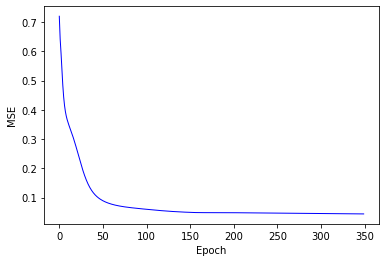

<Figure size 432x288 with 0 Axes>

In [20]:
def plot_graph(color):
    x = range(0, 350)
    y = MSE
    plt.plot(x, y, c=color, lw='1')

def reset_network():
    MSE.clear()
    NETWORK = initialize_network(FEATURES, 5, CLASSES)
    stochastic_gradient_descent(NETWORK, CLASSES, TRAIN)

reset_network()
plot_graph('blue')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()
plt.clf()

So, we see the MSE reduces over time but at a point does stop improving (around epoch 100). The MSE (or SSE) is inversely correlated to the network performance, too, so you will know that an appropriate training termination condition is around the same number of epochs. In other words, design your network to train until a certain threshold, then stop, as you get diminishing returns going further.

## Different Learning and Momentum Rates

I made a statement earlier without backing it up that the learning and momentum rates can influence the training and that it was problem specific. I want to illustrate how different values for each can be used and show their effect.

Below I'll plot different learning rates and choose the best one to test momentum rates:

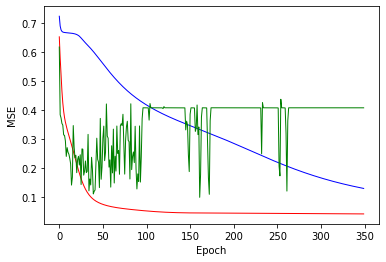

<Figure size 432x288 with 0 Axes>

In [21]:
MOMENTUM_RATE = 0.000

LRN_RATES = [0.010, 0.100, 1.000]
LRN_COLOR = ['blue', 'red', 'green']

for i in range(3):
    LEARNING_RATE = LRN_RATES[i]
    reset_network()
    plot_graph(LRN_COLOR[i])
    
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()
plt.clf()

You'll see the blue line (learning rate of `0.01`) took a lot longer to converge (actually, it didn't in this graph but would have if it were 450-500 epochs), the red line (learning rate of `0.10`) converged quickly to a solution, and the green line (a learning rate of `1.00`) began to converge but as it reached the 10th epoch, began to overcorrect weights and actually regress to a worse MSE at many points. From this we can deduce a learning rate of `0.10` is ideal.

What you should take from this is that a higher learning rate is not necessarily better as you may overshoot an ideal weight, here denoted by rapidly changing MSE.

Next, we can see how momentum rate can affect performance when paired with an optimal learning rate:

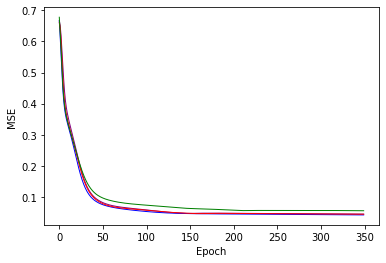

<Figure size 432x288 with 0 Axes>

In [22]:
LEARNING_RATE = 0.100

MOM_RATES = [0.000, 0.001, 0.010, 0.100]
MOM_COLOR = ['purple', 'blue', 'red', 'green']

for i in range(4):
    MOMENTUM_RATE = MOM_RATES[i]
    reset_network()
    plot_graph(MOM_COLOR[i])

plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()
plt.clf()

We can see the purple line (no momentum) converges quickly but the blue line (momentum rate of `0.001`) converges slightly faster. The worst performer was the green line (momentum rate of `0.100`) which did converge to close to global minima but did not perform as well as the other three. A momentum rate of `0.001` is ideal if just because it converged a few epochs sooner.

The Iris data set is a poor example to examine momentum rate, but were you to try on higher dimensional data, you'd see a poor momentum rate would converge early to an non-optimal solution, suggesting the gradient descent got trapped in a local minima and failed to find the global minima. You can somewhat see this with the green line but it is difficult to discern the actual impact to performance. As mentioned before, not every problem will demand the use of momentum.

This is all just playing around with parameters, though. This is just to illustrate that parameter choice is important, but you should do your own experiments with your own data to see what works. You can also change the hidden layer structure as a parameter, but I just kept it simple.

## Final Thoughts

By using a neural network, you can approach classification problems with relative ease. If you have in mind good parameters and a nice hidden layer(s) structure, a neural network can be applied to any kind of data provided you have some already classified data first.

From this tutorial you should have learned a very high-level idea of what a neural network is and how it works, and you would have learned how to implement a vanilla backpropagation network.

There are still things you can experiment with: using multiple hidden layers, doing batch learning rather than online learning, even some of the different types of neural network training schemes like resilient backpropagation and Quickprop. This tutorial only covers the absolute basics. You may also wish to investigate more of the math involved as I have explained very little here.

I hope this tutorial helps if you were confused with or just wanted to implement a neural network.

## Finished Code

Here is the full uncommented code along with one final plot of the MSE and accuracy over time:

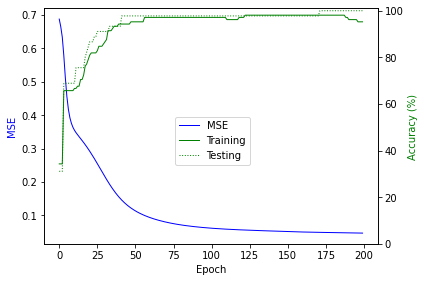

<Figure size 432x288 with 0 Axes>

In [23]:
#!/usr/bin/env python3

import random
import csv
import matplotlib.pyplot as plt
from math import exp, floor, ceil

def stochastic_gradient_descent(network, classes, training_data):
    for _ in range(0, EPOCHS):
        first_example = True
        total_error = 0.00
        for example in training_data:
            temporal_delta = [neuron['d'] \
                for layer in network for neuron in layer] \
                if not first_example else None
            outputs = [0 for _ in range(classes)]
            outputs[int(example[-1])] = 1
            actual = feed_forward(network, example)
            total_error += sse(actual, outputs)
            backpropagate(network, outputs)
            update_weights(network, example, temporal_delta)
            reset_neurons(network)
            first_example = False
        MSE.append(total_error/len(training_data))
        TRP.append(performance_measure(NETWORK, TRAIN))
        TEP.append(performance_measure(NETWORK, TEST))

def feed_forward(network, example):
    layer_input, layer_output = example, []
    for layer in network:
        for neuron in layer:
            summ = summing_function(neuron['w'], layer_input)
            neuron['o'] = activation_function(summ)
            layer_output.append(neuron['o'])
        layer_input, layer_output = layer_output, []
    return layer_input

def backpropagate(network, example):
    for i in range(len(network)-1, -1, -1):
        for j in range(len(network[i])):
            err = 0.00
            if i == len(network)-1:
                err = example[j] - network[i][j]['o']
            else:
                summ = 0.00
                for neuron in network[i+1]:
                    summ += neuron['w'][j] * neuron['d']
                err = summ
            network[i][j]['d'] = activation_derivative(network[i][j]['o']) * err

def reset_neurons(network):
    for layer in network:
        for neuron in layer:
            neuron['o'] = 0

def update_weights(network, example, delta):
    for i in range(len(network)):
        if i != 0:
            t = [neuron['o'] for neuron in network[i-1]]
        else:
            t = example[:-1]
        for neuron, d in zip(network[i], range(0, len(network[i]))):
            for f in range(len(t)):
                neuron['w'][f] += LEARNING_RATE * float(t[f]) * neuron['d']
                if delta is not None:
                    neuron['w'][f] += MOMENTUM_RATE * delta[d]
                neuron['w'][-1] += LEARNING_RATE * neuron['d']

def sse(actual, target):
    summ = 0.00
    for i in range(len(actual)):
        summ += (actual[i] - target[i])**2
    return summ

def activation_function(z):
    return 1 / (1 + exp(-z))

def activation_derivative(z):
    return z * (1 - z)

def summing_function(weights, inputs):
    bias = weights[-1]
    summ = 0.00
    for i in range(len(weights)-1):
        summ += (weights[i] * float(inputs[i]))
    return summ + bias

def performance_measure(network, data):
    correct, total = 0, 0
    for example in data:
        if check_output(network, example) == float(example[-1]):
            correct += 1
        total += 1
    return 100*(correct / total)

def check_output(network, example):
    output = feed_forward(network, example)
    return output.index(max(output))

def initialize_network(n, h, o):
    def r():
        return random.uniform(-0.50, 0.50)
    neural_network = []
    neural_network.append([{'w':[r() for i in range(n+1)]} for j in range(h)])
    neural_network.append([{'w':[r() for i in range(h+1)]} for j in range(o)])
    return neural_network

def load_data(filename):
    with open(filename, newline='\n') as csv_file:
        data = []
        rows = csv.reader(csv_file, delimiter=',')
        for row in rows:
            data.append(row)
    random.shuffle(data)
    training_data = data[:floor(len(data)*0.70)]
    testing_data = data[-ceil(len(data)*0.30):]
    return training_data, testing_data

def plot_data():
    x = range(0, EPOCHS)
    fig, ax2 = plt.subplots()
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE', color='blue')
    line, = ax2.plot(x, MSE, '-', c='blue', lw='1', label='MSE')
    ax1 = ax2.twinx()
    ax1.set_ylabel('Accuracy (%)', color='green')
    line2, = ax1.plot(x, TRP, '-', c='green', lw='1', label='Training')
    line3, = ax1.plot(x, TEP, ':', c='green', lw='1', label='Testing')
    fig.tight_layout()
    fig.legend(loc='center')
    ax1.set_ylim(0, 101)
    plt.show()
    plt.clf()

if __name__ == '__main__':
    TRAIN, TEST = load_data('./data/iris.csv')
    FEATURES = len(TRAIN[0][:-1])
    CLASSES = len(list(set([c[-1] for c in TRAIN])))
    NETWORK = initialize_network(FEATURES, 5, CLASSES)
    LEARNING_RATE, MOMENTUM_RATE = 0.100, 0.001
    EPOCHS = 200
    MSE, TRP, TEP = [], [], []
    stochastic_gradient_descent(NETWORK, CLASSES, TRAIN)
    plot_data()

You may wish to catch for errors (as I have done none here), and perhaps accept some of the parameters as command line arguments. This code, as-is, should run in a terminal but allows for zero customization unless you change the code manually. Some parameters might include hidden layer size, learning and momentum rates, even selection of activation function if you choose to implement another.

You can save this code as `backprop_network.py` and execute it as one of the below:

```
$ python3 backprop_network.py
$ ./backprop_network.py
```

You can also find the code in `./code` and a more fleshed out version with error handling, command-line arguments, etc. <a href="https://github.com/stratzilla/backprop-neural-network">here</a>.